In [1]:
import pandas as pd
import numpy as np
from common import *
from glob import glob
from os import rename, path
from gensim import corpora
from os.path import basename

from matplotlib import pyplot as plt
import logging

from tqdm import tqdm

import gensim
from gensim import corpora, models, similarities

DATA_FOLDER = '../data/'
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
%%time
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'old.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'corpus.mm'))

2017-07-17 14:35:48,695 : INFO : loading Dictionary object from ../data/old.dict
2017-07-17 14:35:50,931 : INFO : loaded ../data/old.dict
2017-07-17 14:35:51,064 : INFO : loaded corpus index from ../data/corpus.mm.index
2017-07-17 14:35:51,065 : INFO : initializing corpus reader from ../data/corpus.mm
2017-07-17 14:35:51,066 : INFO : accepted corpus with 1194670 documents, 3496903 features, 192261307 non-zero entries


CPU times: user 2.11 s, sys: 260 ms, total: 2.37 s
Wall time: 2.37 s


In [3]:
print(corpus)

MmCorpus(1194670 documents, 3496903 features, 192261307 non-zero entries)


In [4]:
%%time
fmodel = join(DATA_FOLDER, 'tfidf.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

2017-07-17 14:35:51,099 : INFO : loading TfidfModel object from ../data/tfidf.model
2017-07-17 14:35:51,764 : INFO : loaded ../data/tfidf.model


CPU times: user 576 ms, sys: 92 ms, total: 668 ms
Wall time: 667 ms


In [58]:
# %%time
# index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary), num_best=200)

In [5]:
%%time
fname = join(DATA_FOLDER, 'sim_index/sim')
if not exists(fname):
    index = similarities.Similarity(fname, tfidf[corpus], 
                                    num_features=len(dictionary), num_best=200, 
                                    chunksize=4*256, shardsize=5*32768)
    index.save(fname)
else:
    index = similarities.Similarity.load(fname)

2017-07-17 14:35:51,774 : INFO : loading Similarity object from ../data/sim_index/sim
2017-07-17 14:35:51,775 : INFO : loaded ../data/sim_index/sim


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.28 ms


### Test all

In [6]:
with open(join(DATA_FOLDER, 'gold.txt'), 'r') as f:
    gold_txt = f.read()
lines = gold_txt.splitlines()
gold = {line.split()[0]:line.split()[1:] for line in lines}

In [8]:
# DATA_FOLDER = '../data/'
# test_docs = []
# for root, directories, filenames in os.walk(join(DATA_FOLDER, 'FIPS/test/')):
#     test_docs += [join(root,f) for f in filenames]

In [9]:
# for f in test_docs:
#     if not '.txt' in f:
#         rename(f, f + '.txt')

In [7]:
test_docs = glob(join(DATA_FOLDER, 'docs/*.txt'))

In [8]:
preds = {}
for fname in tqdm(test_docs):
    with open(fname, 'r') as f:
        doc_text = f.read()
    vec_bow = dictionary.doc2bow(tokenize(doc_text))
    vec_model = tfidf[vec_bow] # convert the query to model space
    preds[path.splitext(basename(fname))[0]] = index[vec_model]

2017-07-17 14:35:51,841 : INFO : loading SparseMatrixSimilarity object from ../data/sim_index/sim.0
2017-07-17 14:35:52,301 : INFO : loaded ../data/sim_index/sim.0
2017-07-17 14:35:52,341 : INFO : loading SparseMatrixSimilarity object from ../data/sim_index/sim.1
2017-07-17 14:35:52,799 : INFO : loaded ../data/sim_index/sim.1
2017-07-17 14:35:52,848 : INFO : loading SparseMatrixSimilarity object from ../data/sim_index/sim.2
2017-07-17 14:35:52,850 : INFO : loading index from ../data/sim_index/sim.2.index.npy with mmap=r
2017-07-17 14:35:52,853 : INFO : loaded ../data/sim_index/sim.2
2017-07-17 14:35:52,915 : INFO : loading SparseMatrixSimilarity object from ../data/sim_index/sim.3
2017-07-17 14:35:52,917 : INFO : loading index from ../data/sim_index/sim.3.index.npy with mmap=r
2017-07-17 14:35:52,920 : INFO : loaded ../data/sim_index/sim.3
2017-07-17 14:35:53,129 : INFO : loading SparseMatrixSimilarity object from ../data/sim_index/sim.4
2017-07-17 14:35:53,131 : INFO : loading index f

In [9]:
%%time
all_docs = get_all_docs(DATA_FOLDER)

CPU times: user 164 ms, sys: 68 ms, total: 232 ms
Wall time: 230 ms


In [10]:
new_pred = {}
for k, v in preds.items():
    new_pred[k] = [path.splitext(basename(all_docs[key]))[0] for key, sim in v]

In [11]:
# new_pred['e75dcef9-73b5-40c1-45be-33a191b6440c']

median
acc10     0.333333
acc20     0.500000
acc200    1.000000
dtype: float64
mean
acc10     0.437730
acc20     0.516871
acc200    0.751943
dtype: float64


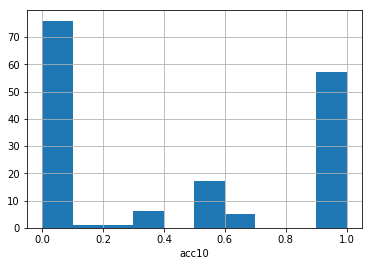

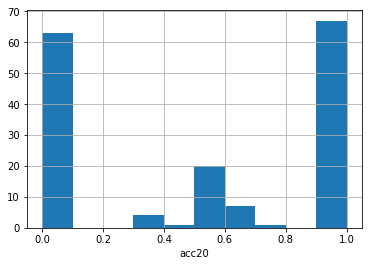

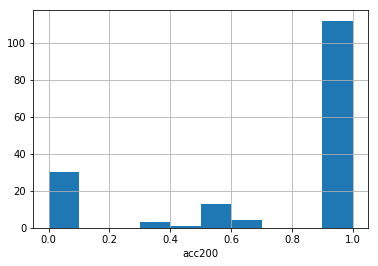

In [13]:
res = evaluate(new_pred, gold)

In [154]:
len([v for v in all_docs if '-' in v])

241

### Test 3


In [29]:
%%time
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'filtered.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'filtered_corpus.mm'))

CPU times: user 580 ms, sys: 68 ms, total: 648 ms
Wall time: 647 ms


In [30]:
print(corpus)

MmCorpus(1194664 documents, 843052 features, 187315959 non-zero entries)


In [31]:
%%time
fmodel = join(DATA_FOLDER, 'tfidf_filtered.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

CPU times: user 8min 32s, sys: 1.53 s, total: 8min 34s
Wall time: 8min 34s


In [32]:
%%time
fname = join(DATA_FOLDER, 'sim_index3/sim')
if not exists(fname):
    index = similarities.Similarity(fname, tfidf[corpus], 
                                    num_features=len(dictionary), num_best=200, 
                                    chunksize=4*256, shardsize=5*32768)
    index.save(fname)
else:
    index = similarities.Similarity.load(fname)

CPU times: user 23min 31s, sys: 3.74 s, total: 23min 34s
Wall time: 23min 34s


In [33]:
preds = {}
for fname in test_docs:
    with open(fname, 'r') as f:
        doc_text = f.read()
    vec_bow = dictionary.doc2bow(tokenize(doc_text))
    vec_model = tfidf[vec_bow] # convert the query to model space
    preds[path.splitext(basename(fname))[0]] = index[vec_model]

In [34]:
new_pred = {}
for k, v in preds.items():
    new_pred[k] = [path.splitext(basename(all_docs[key]))[0] for key, sim in v]

In [52]:
result = []
for key, val in new_pred.items():
    true_val = gold[key]
    gold_len = len(true_val)
    
    inter10 = set(val[0:10]).intersection(true_val)
    inter20 = set(val[0:20]).intersection(true_val)
    inter200 = set(val[0:200]).intersection(true_val)
    
    acc10 = len(inter10)/gold_len
    acc20 = len(inter20)/gold_len
    acc200 = len(inter200)/gold_len
    
    result.append([acc10, acc20, acc200])

result = pd.DataFrame(result, columns=['acc10', 'acc20', 'acc200'])
print(result.median(axis=0))
print(result.mean(axis=0))

acc10     0.333333
acc20     0.500000
acc200    1.000000
dtype: float64
acc10     0.435685
acc20     0.516871
acc200    0.745808
dtype: float64


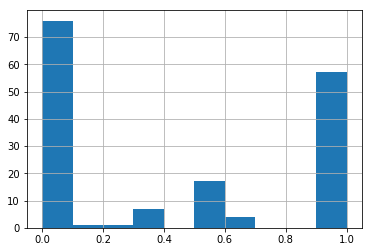

In [48]:
result['acc10'].hist()
plt.show()

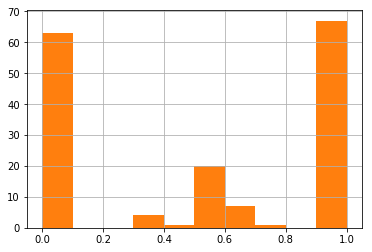

In [50]:
result['acc20'].hist()
plt.show()

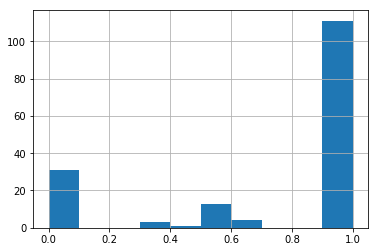

In [51]:
result['acc200'].hist()
plt.show()